In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import sys
import os
import pandas as pd
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.models import load_model
from keras.regularizers import Regularizer


c:\users\shiny\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Parameters
LEARNING_RATE = 0.01
BATCH_SIZE = 50
EPOCHS = 100
scale = 1

input_size = 1
output_size = 2
nodes = 3
input_file = "input_exp2.csv"
output_file = "output_exp2.csv"

model_name = "./exp2_node_3"
model_file = model_name+'/model.hdf5'
weight_file = model_name+'/best_weights.h5'

In [3]:
def CreateModel(input_shape,output_shape):
    input_para = Input((input_shape,), name = 'input_para')
    x = Dense(nodes,activation = 'tanh')(input_para)
    x= Dense(nodes,activation = 'tanh')(x)
    output = Dense(output_shape,activation = 'tanh')(x)
    
    model = Model(inputs = input_para, outputs = output, name = 'Mode')
    
    return model

In [4]:
def read_data_from_file(feature_num,label_num,filename_x, filename_y,testing_ratio = 0.02):
    FEATURES = []
    LABELS = []

    for i in range (feature_num):
        FEATURES.append(str(i))
    for j in range (label_num):
        LABELS.append('a'+str(j))
    raw_feature = pd.read_csv(filename_x, header=None,skipinitialspace=False,names=FEATURES)
    raw_label = pd.read_csv(filename_y, header=None,skipinitialspace=False,names=LABELS)

# Split all samples into to category: for_training and for_testing
    testing_number = int(testing_ratio*raw_feature.shape[0])

    print('there are {} testing samples, and {} training samples'.format(testing_number,raw_feature.shape[0]-testing_number))
    import random
    testing_samples_index = []
    training_samples_index = []
    random.seed(a=1)
    for i in range(testing_number):
        test_ind = random.randint(0,raw_feature.shape[0])
        testing_samples_index.append(test_ind)
        print(test_ind)
    training_samples_index = list(set(range(raw_feature.shape[0])).difference(set(testing_samples_index)))

    test_x = pd.DataFrame(raw_feature.loc[testing_samples_index, :].mul(scale), columns =FEATURES,dtype = np.float32).as_matrix()
    test_y =  pd.DataFrame(raw_label.loc[testing_samples_index, :].mul(scale)).as_matrix()
    train_x = pd.DataFrame(raw_feature.loc[training_samples_index, :].mul(scale),columns =FEATURES,dtype = np.float32).as_matrix()
    train_y = pd.DataFrame(raw_label.loc[training_samples_index,:].mul(scale)).as_matrix()

    return train_x, train_y, test_x, test_y, testing_samples_index


In [5]:
def print_predict_to_file(pred_y,test_y,testing_samples_index):
    for i in range(len(testing_samples_index)):
        pred_i = pred_y[i,:]
        true_i = test_y[i,:]
        filename = './{}/{}_prediction.csv'.format(model_name,str(testing_samples_index[i]))
        np.savetxt(filename,pred_i,delimiter = ",")
        

In [6]:
def main(argv):
    # Data processing
    directory = './'+model_name
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    train_x, train_y, test_x, test_y, testing_samples_index = read_data_from_file(input_size,output_size,input_file, output_file)
    test_sample_name = './'+model_name+'/sample_index.txt'
    np.savetxt(test_sample_name,testing_samples_index,fmt = '%i',delimiter = '\n')
    # Load or create model
    try:
        model = load_model(model_file)
        model.load_weights(weight_file)
    except:
        model = CreateModel(input_size,output_size)
        sgd = SGD(lr=LEARNING_RATE)
        model.compile(loss = 'mse', optimizer = sgd, metrics = ['mse'])
    
    model.summary()
    checkpointer = ModelCheckpoint(filepath = weight_file,
                                   monitor = 'val_loss',
                                   verbose = 0,
                                   save_best_only = True,
                                   save_weights_only = False,
                                   mode = 'auto')
    history = model.fit(train_x, train_y,
                        epochs = EPOCHS,
                        batch_size = BATCH_SIZE,
                        shuffle = True,
                        verbose = 1,
                        callbacks = [checkpointer],
                        validation_data = (test_x, test_y))
    model.save(model_file)
    
    # Plotting training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'], loc = 'upper right')
    plt.show()
    
    pred_y = model.predict(test_x)
    print_predict_to_file(pred_y, test_y, testing_samples_index)
    
    

there are 20 testing samples, and 981 training samples
137
582
867
821
782
64
261
120
507
779
460
483
667
388
807
214
96
499
29
914
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_para (InputLayer)      (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________
Train on 981 samples, validate on 20 samples
Epoch 1/100
981/981 [==============================] - 0s 351us/step - loss: 5.1052 - mean_squared_er

981/981 [==============================] - 0s 45us/step - loss: 3.1219 - mean_squared_error: 3.1219 - val_loss: 3.1040 - val_mean_squared_error: 3.1040
Epoch 45/100
981/981 [==============================] - 0s 41us/step - loss: 3.1213 - mean_squared_error: 3.1213 - val_loss: 3.1034 - val_mean_squared_error: 3.1034
Epoch 46/100
981/981 [==============================] - 0s 33us/step - loss: 3.1207 - mean_squared_error: 3.1207 - val_loss: 3.1028 - val_mean_squared_error: 3.1028
Epoch 47/100
981/981 [==============================] - 0s 37us/step - loss: 3.1202 - mean_squared_error: 3.1202 - val_loss: 3.1022 - val_mean_squared_error: 3.1022
Epoch 48/100
981/981 [==============================] - 0s 33us/step - loss: 3.1196 - mean_squared_error: 3.1196 - val_loss: 3.1017 - val_mean_squared_error: 3.1017
Epoch 49/100
981/981 [==============================] - 0s 41us/step - loss: 3.1191 - mean_squared_error: 3.1191 - val_loss: 3.1011 - val_mean_squared_error: 3.1011
Epoch 50/100
981/981 [=

Epoch 94/100
981/981 [==============================] - 0s 53us/step - loss: 3.1080 - mean_squared_error: 3.1080 - val_loss: 3.0893 - val_mean_squared_error: 3.0893
Epoch 95/100
981/981 [==============================] - 0s 37us/step - loss: 3.1079 - mean_squared_error: 3.1079 - val_loss: 3.0892 - val_mean_squared_error: 3.0892
Epoch 96/100
981/981 [==============================] - 0s 33us/step - loss: 3.1078 - mean_squared_error: 3.1078 - val_loss: 3.0891 - val_mean_squared_error: 3.0891
Epoch 97/100
981/981 [==============================] - 0s 41us/step - loss: 3.1077 - mean_squared_error: 3.1077 - val_loss: 3.0890 - val_mean_squared_error: 3.0890
Epoch 98/100
981/981 [==============================] - 0s 41us/step - loss: 3.1076 - mean_squared_error: 3.1076 - val_loss: 3.0888 - val_mean_squared_error: 3.0888
Epoch 99/100
981/981 [==============================] - 0s 45us/step - loss: 3.1075 - mean_squared_error: 3.1075 - val_loss: 3.0887 - val_mean_squared_error: 3.0887
Epoch 100/

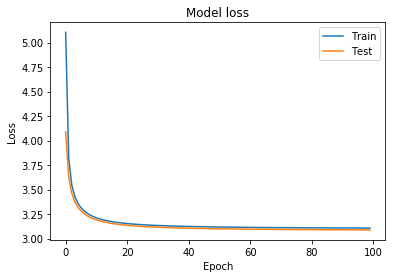

In [8]:
if __name__=="__main__":
    main(sys.argv)